In [748]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [749]:
base = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'
                     ,encoding="latin1"
                     ,skiprows=4
                     ,nrows=348)
base.columns = ['city', 'population', 'violent_crime','murder','rape_1', 'rape_2',
       'robbery', 'aggravated', 'property', 'burglary',
       'theft', 'motor', 'arson']

# Understanding the data

## Correlations

First let's look at the initial correlations to understand what we have

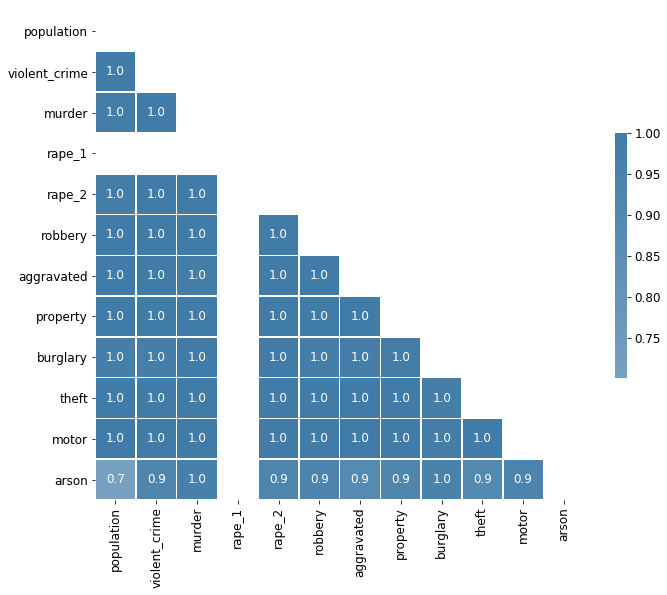

In [750]:
cmap = sns.diverging_palette(128, 240,as_cmap=True)
plt.rcParams.update({'font.size': 12})
def show_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr,  mask=mask,cmap=cmap, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt='.1f'
               );
show_corr(base)

In [751]:
display(base.head(3))
print(base.rape_1.unique())

,city,population,violent_crime,murder,rape_1,rape_2,robbery,aggravated,property,burglary,theft,motor,arson
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000


[nan]


We notice that all the variables are highly corraleted!

The assumption is that all variable are dependent on the population (the number are total number of crime per category, so there is a link between the population and all the crime numbers).

We also notice that the variable rape_1 is actually only N/A values

In [752]:
per_pop = base.copy()
per_pop = per_pop.drop(['city','rape_1'],axis=1)
for col in ['violent_crime','murder', 'rape_2','robbery', 'aggravated', 'property', 'burglary','theft', 'motor']:
    per_pop[col] = per_pop[col]/per_pop.population

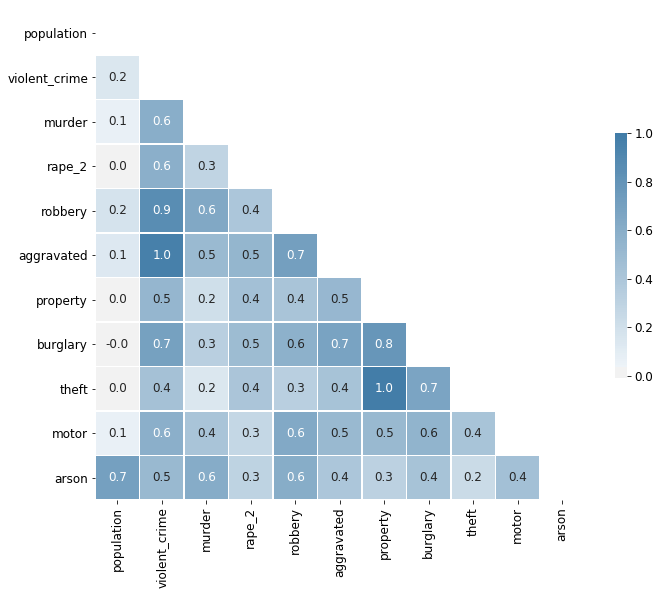

In [753]:
show_corr(per_pop)

That is much better !

Having the crime rates allows us to notice that there is a very high correlation between *property* crimes and *theft*, we could make a first model base on that !

Also, apart from *arson*, we can also see that there is very little correlation between the population of the city and the different crime rate, especially for the type of crime we are looking into : *property* and *theft*.

Text(0.5,1,'Theft and Property crime (per population)')

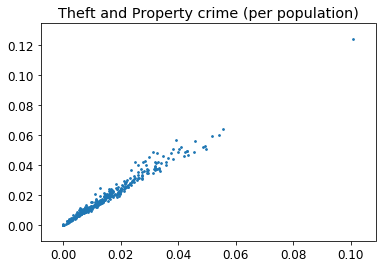

In [754]:
plt.scatter(per_pop.theft,per_pop.property,s=3)
plt.title("Theft and Property crime (per population)")

Indeed they seem very correlated graphically!

We notice there is an outlier : it seems to be aligned with the rest of the group, but we will need to make sure it does not have a disproportionate influence on the regression.

Coefficients: 
 [1.18099717]
Intercept: 
 0.0008224361899665626
Train score: 0.9687579043360584
Test score: 0.9808555515374818


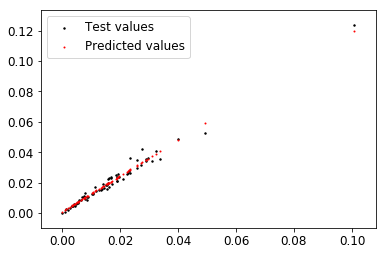

In [755]:
x = per_pop[['theft']]
y = per_pop.property
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train,y_train)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print("Train score:",regr.score(X_train,y_train))
print("Test score:",regr.score(X_test,y_test))
# Plot outputs
plt.scatter(X_test,y_test, color='black',s=2,label="Test values")
plt.scatter(X_test, regr.predict(X_test), color='red',s=1,label="Predicted values")
plt.legend()
plt.show()

Text(0.5,1,'Residual histogram')

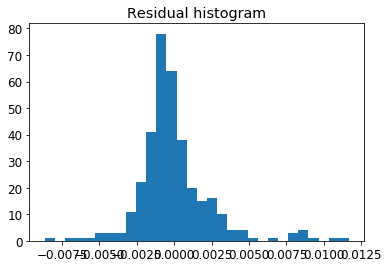

In [756]:
predicted = regr.predict(x)
residual = y - predicted
plt.hist(residual,bins=30);
plt.title("Residual histogram")

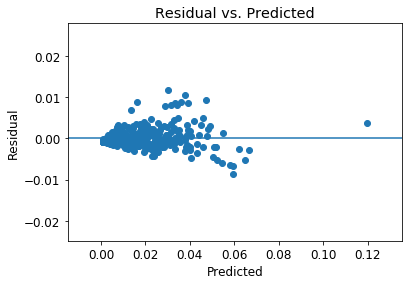

In [757]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [758]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, x, y, cv=10)

array([0.98215096, 0.95805669, 0.97711197, 0.96643604, 0.98414612,
       0.95311385, 0.97278007, 0.93736237, 0.98521257, 0.94555448])

# First regression discussion

Indeed we are able to explain around 95% of the value of the Property crime per population.

The residual is almost normally distributed, but they are a couple of errors that are higher than expected further from 0.

Also the plot of the residual and expected show some heteroscedasticity.

As this is only our first regression with one variable, we will try to improve it with the other variables.

We also notice the outlier variable is visible on the graph and present a higher than expected error : this seems like it is related to the population, looking at the distribution of population there is only one city of more than 1 million inhabitant : this outlier might have a disproportionnate influence on the regression so we will take it out.

Also, **Arson** behave in a strange manner, with N/A that is linked to the way the crime are reported. The median value in 0, so we can safely replace N/A by 0, but we will recorded the value that are N/A with a categorical value.

# Second regression

As there are not many variable, and we already have a very good prediction with theft, let's look iteratively at the features, using the minimum of the cross validation test score.

In [992]:
for_reg = per_pop.sort_values("population").reset_index().fillna(0)
y = for_reg[["property"]]

for col in ['population', 'violent_crime', 'murder', 'rape_2', 'robbery',
       'aggravated',  'motor', 'arson',]:
    x = for_reg[['theft', 'burglary', col]]
    print(col,min(cross_val_score(regr, x, y, cv=15)))

population 0.6988700459160666
violent_crime 0.9954780632389395
murder 0.9952512586580933
rape_2 0.993941873066868
robbery 0.9975899816013971
aggravated 0.9945121337653015
motor 1.0
arson 0.9816383298786536


In [997]:
x = for_reg[['theft', 'burglary', 'motor']]
cross_val_score(regr, x, y, cv=35)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

Coefficients: 
 [[1. 1. 1.]]
Intercept: 
 [0.]
Train score: 1.0
Test score: 1.0


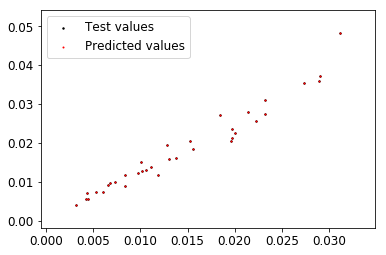

In [1006]:

y = for_reg[["property"]]
x = for_reg[['theft', 'burglary',"motor"]]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train,y_train)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print("Train score:",regr.score(X_train,y_train))
print("Test score:",regr.score(X_test,y_test))
# Plot outputs
plt.scatter(X_test.theft,y_test, color='black',s=2,label="Test values")
plt.scatter(X_test.theft, regr.predict(X_test), color='red',s=1,label="Predicted values")
plt.legend()
plt.show()

# Getting the R2 score for the **Property Crime**

The regression was on the property crime per population, let's check the R2 for the actual R2 value.

In [761]:
from sklearn.metrics import r2_score
for_r2 = X_test.merge(for_reg[["population"]],left_index=True, right_index=True)
#r2_score((for_r2.population*y_test.T).T, for_r2.population*[x[0] for x in regr.predict(X_test)], multioutput='variance_weighted')

1.0

# Second regression conclusion

This result is very surprising, it really looks like a data leak ! It seems that Property = Theft + Burglary + Motor 

To make it a little more interesting, let's look at the data without those 3 values and try to find a good prediction.



# Doing some PCA...

In [941]:
per_pop = base.copy()
per_pop = per_pop.drop(['city','rape_1'],axis=1)
for col in ['violent_crime','murder', 'rape_2','robbery', 'aggravated', 'property', 'burglary','theft', 'motor']:
    per_pop[col] = per_pop[col]/per_pop.population

In [942]:
crime_pca = per_pop[['violent_crime','murder', 'rape_2','robbery', 'aggravated']].copy()
sklearn_pca = PCA(n_components=5)
X = StandardScaler().fit_transform(crime_pca)
Y_sklearn = sklearn_pca.fit_transform(X)

In [943]:
display(sklearn_pca.components_)
display(sklearn_pca.explained_variance_)

array([[ 0.52267807,  0.38322004,  0.34857194,  0.47116106,  0.48626627],
       [ 0.04912066, -0.5800384 ,  0.75651224, -0.27082524,  0.12444091],
       [ 0.28028294, -0.6584962 , -0.52749859,  0.18090109,  0.42052855],
       [ 0.08159289,  0.28792408, -0.14977962, -0.77184092,  0.54061999],
       [-0.79948663,  0.01342881,  0.07414943,  0.27603864,  0.52815275]])

array([3.51936902e+00, 7.60706399e-01, 4.82508060e-01, 2.51825741e-01,
       1.07851052e-31])

In [1047]:
sum(sklearn_pca.explained_variance_ratio_[:3])

0.9497795791456156

In [944]:
for i in range(5):
    per_pop[f"pca_{i}"] = Y_sklearn[:,i]

per_pop["is_arson"] = per_pop.arson.isna()
per_pop = per_pop.fillna(0)
#per_pop = per_pop.drop(['theft', 'burglary',"motor"],axis=1)

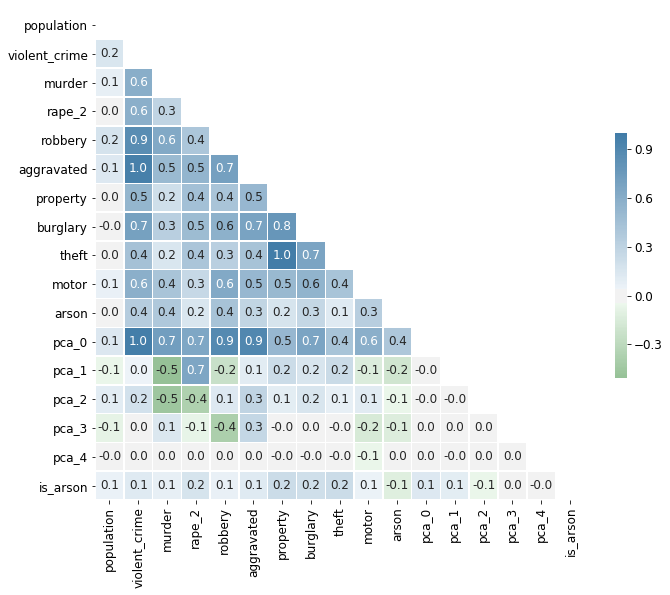

In [945]:
show_corr(per_pop)

# Third regression




## Very bad fit !

In [823]:
for_reg = per_pop[per_pop.population<1000000].sort_values("population").reset_index()
#for_reg = per_pop[~per_pop.arson.isna()].sort_values("population").reset_index()

y = for_reg[["property"]]
x = for_reg[['pca_0', 'pca_1', 'pca_2','is_arson','arson']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40)
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train,y_train)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print("Train score:",regr.score(X_train,y_train))
print("Test score:",regr.score(X_test,y_test))
# Plot outputs
#plt.scatter(X_test.pca_0,y_test, color='black',s=2,label="Test values")
#plt.scatter(X_test.pca_0, regr.predict(X_test), color='red',s=1,label="Predicted values")
#plt.legend()
#plt.show()

Coefficients: 
 [[ 0.00583329  0.00226337  0.00507798  0.         -0.00228573]]
Intercept: 
 [0.02148309]
Train score: 0.3473450441153516
Test score: -3.5383435264011163


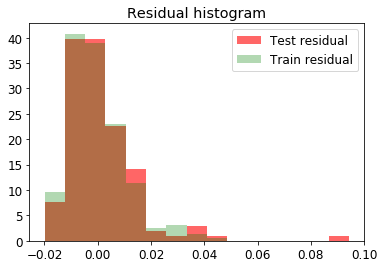

In [817]:
predicted_test = regr.predict(X_test)
predicted_train = regr.predict(X_train)

residual_test = y_test - predicted_test
residual_train = y_train - predicted_train
_,bins,_ = plt.hist(residual_test.property,color="red",bins=15,alpha=0.6,density=True,label="Test residual");
plt.hist(residual_train.property,color="green",bins=bins,alpha=0.3,density=True,label="Train residual");
plt.legend()
plt.title("Residual histogram");

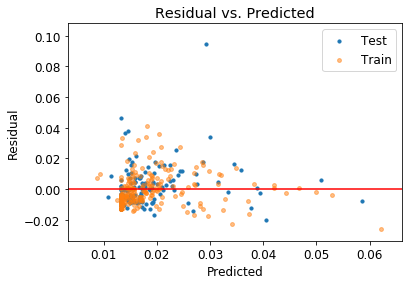

In [818]:
plt.scatter(predicted_test, residual_test.property,s=10,label="Test")
plt.scatter(predicted_train, residual_train.property,s=15,alpha=0.5,label="Train")

plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0,color="red")
plt.title('Residual vs. Predicted')
plt.legend()
plt.show()

In [819]:
from sklearn.metrics import r2_score
for_r2 = X_test.merge(for_reg[["population"]],left_index=True, right_index=True)
r2_score((for_r2.population*y_test.T).T, for_r2.population*[x[0] for x in regr.predict(X_test)], multioutput='variance_weighted')

0.8955860322900113

Eventhoug we get a very bad score for the property crim rate, we still end up with a very high score for the number of property crime as it is dependant on the population mostly.

But looking at the test and train, we realize that the train has no 'is_arson', when the rest of the values are comparable.

In [824]:
sum(X_train.is_arson)

0

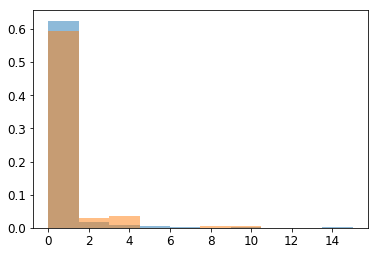

In [835]:
_,bins,_ = plt.hist(X_train.arson,density=True,alpha=0.5)
_,bins,_ = plt.hist(X_test.arson,bins=bins,density=True,alpha=0.5)


In [856]:
per_pop.is_arson.unique()

array([False,  True])

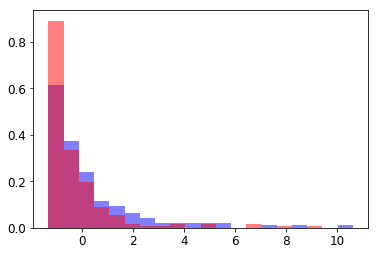

In [861]:
_,bins,_ = plt.hist(per_pop[per_pop.is_arson==True].pca_0,bins=20,density=True,alpha=0.5,color="blue");
plt.hist(per_pop[per_pop.is_arson==False].pca_0,bins=bins,density=True,alpha=0.5,color="red");


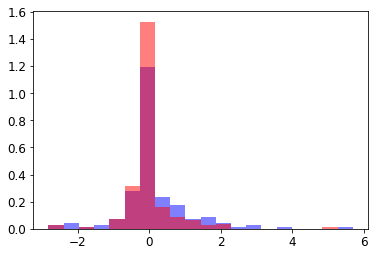

In [862]:
_,bins,_ = plt.hist(per_pop[per_pop.is_arson==True].pca_1,bins=20,density=True,alpha=0.5,color="blue");
plt.hist(per_pop[per_pop.is_arson==False].pca_1,bins=bins,density=True,alpha=0.5,color="red");


## Controling the train and test are comparable

There is an overal difference between cities that report arson correctly and the others, we need to make sure the number of 'is_arson' is almost the same in train and test.

In [1049]:
for_reg = per_pop[per_pop.population<1000000].sort_values("population").reset_index()
#for_reg = per_pop[~per_pop.arson.isna()].sort_values("population").reset_index()

y = for_reg[["property"]]
x = for_reg[['pca_0', 'pca_1',"pca_2"]]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train,y_train)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print("Train score:",regr.score(X_train,y_train))
print("Test score:",regr.score(X_test,y_test))
# Plot outputs
#plt.scatter(X_test.pca_0,y_test, color='black',s=2,label="Test values")
#plt.scatter(X_test.pca_0, regr.predict(X_test), color='red',s=1,label="Predicted values")
#plt.legend()
#plt.show()
test_arson = X_test.merge(for_reg[["is_arson"]],left_index=True, right_index=True)
train_arson = X_train.merge(for_reg[["is_arson"]],left_index=True, right_index=True)

print("Check Arson train",sum(train_arson.is_arson)/train_arson.shape[0])
print("Check Arson test",sum(test_arson.is_arson)/test_arson.shape[0])

Coefficients: 
 [[0.00401347 0.00375692 0.00232556]]
Intercept: 
 [0.01985029]
Train score: 0.30136373478732703
Test score: 0.673643768307089
Check Arson train 0.46153846153846156
Check Arson test 0.45714285714285713


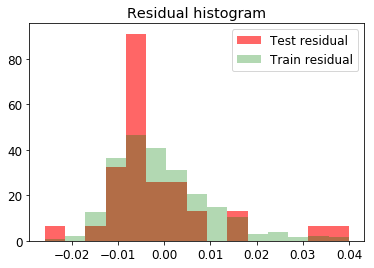

In [1040]:
predicted_test = regr.predict(X_test)
predicted_train = regr.predict(X_train)

residual_test = y_test - predicted_test
residual_train = y_train - predicted_train
_,bins,_ = plt.hist(residual_test.property,color="red",bins=15,alpha=0.6,density=True,label="Test residual");
plt.hist(residual_train.property,color="green",bins=bins,alpha=0.3,density=True,label="Train residual");
plt.legend()
plt.title("Residual histogram");

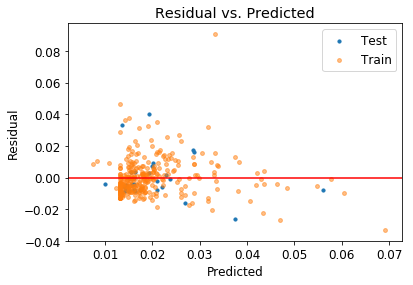

In [1041]:
plt.scatter(predicted_test, residual_test.property,s=10,label="Test")
plt.scatter(predicted_train, residual_train.property,s=15,alpha=0.5,label="Train")

plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0,color="red")
plt.title('Residual vs. Predicted')
plt.legend()
plt.show()

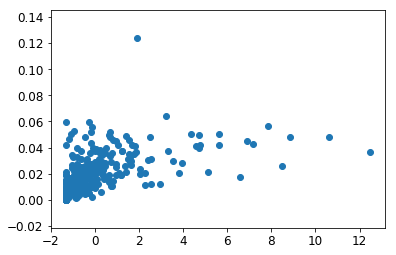

In [1051]:
plt.scatter(x.pca_0,y.property)

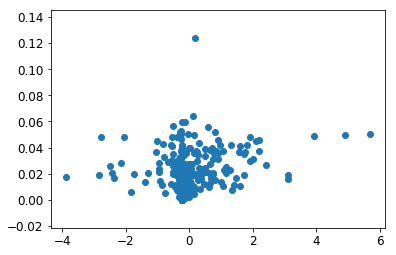

In [1052]:
plt.scatter(x.pca_1,y.property)

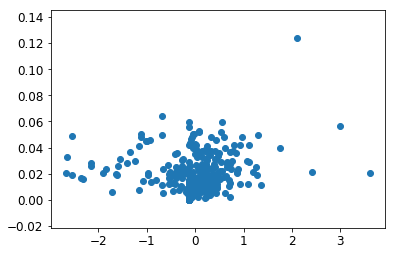

In [1053]:
plt.scatter(x.pca_2,y.property)

In [1050]:
cross_val_score(regr, x, y, cv=5)

array([ 0.17068117,  0.26413689,  0.31567778,  0.36326993, -0.90784811])

In [1021]:
from sklearn.metrics import r2_score
for_r2 = X_test.merge(for_reg[["population"]],left_index=True, right_index=True)
r2_score((for_r2.population*y_test.T).T, for_r2.population*[x[0] for x in regr.predict(X_test)], multioutput='variance_weighted')

0.9272283169142042

In the this final regression, we still have some outliers.

In [981]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [982]:
per_pop.columns

Index(['population', 'violent_crime', 'murder', 'rape_2', 'robbery',
       'aggravated', 'property', 'burglary', 'theft', 'motor', 'arson',
       'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'is_arson'],
      dtype='object')

In [983]:
#per_pop = base.copy()
#per_pop = per_pop.drop(['city','rape_1'],axis=1)
for col in ['violent_crime','murder', 'rape_2','robbery', 'aggravated', 'property', 'burglary','theft', 'motor']:
    base[col+"_per_pop"] = base[col]/base.population

In [984]:
base.columns

Index(['city', 'population', 'violent_crime', 'murder', 'rape_1', 'rape_2',
       'robbery', 'aggravated', 'property', 'burglary', 'theft', 'motor',
       'arson', 'violent_crime_per_pop', 'murder_per_pop', 'rape_2_per_pop',
       'robbery_per_pop', 'aggravated_per_pop', 'property_per_pop',
       'burglary_per_pop', 'theft_per_pop', 'motor_per_pop'],
      dtype='object')

In [1025]:
linear_formula = 'property_per_pop ~ violent_crime_per_pop+rape_2_per_pop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=base).fit()

In [1026]:
lm.params

Intercept                0.013
violent_crime_per_pop    2.883
rape_2_per_pop          15.674
dtype: float64

In [1027]:
lm.pvalues

Intercept               0.000
violent_crime_per_pop   0.000
rape_2_per_pop          0.000
dtype: float64

In [1028]:
lm.rsquared

0.31064349646576905